<a href="https://colab.research.google.com/github/tyleryou/housing_data/blob/main/housing_data_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Housing Prices Using Regression Models**

The following Python script is meant to simulate a data pipeline that begins with data ingestion, followed by transformation and then model building. This could be compared to an ELT pipeline, where the data is extracted, loaded and then transformed for analysis. 

The data set comes from the Kaggle academic competition at the following link:
 https://www.kaggle.com/c/house-prices-advanced-regression-techniques

 This data was chosen as a means to practice feature engineering & regression modeling. I take no ownership of the data. Anyone is free to use the code from this notebook as they see fit.

 If anyone would like to give feedback on the coding choices, methods or explanations I used at any point, please email me at tyler.you@protonmail.com. 

#  Data Ingestion

In [116]:
import sklearn
import numpy as np                 # Linear Algebra Calculations
import matplotlib.pyplot as plt    # Data Plotting
import pandas as pd                # DataFrames
pd.options.mode.chained_assignment = None  # default='warn', turn off warning errors when writing pandas dataframes over original dataframe.
import seaborn as sns              # Data Visualization

In [117]:
## Importing the data from github repository.

url = 'https://raw.githubusercontent.com/tyleryou/housing_data/main/train.csv'

trainingset = pd.read_csv(url)

url_test = 'https://raw.githubusercontent.com/tyleryou/housing_data/main/test.csv'

testset = pd.read_csv(url_test)

In [118]:
## We see the median is pretty far from the mean, so that means the data is skewed. Since the mean is greater than the median, it's likely the target is skewed in the positive direction. MOVE THIS LOWER.

trainingset['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

First off is to look at the prediction target, 'SalePrice'. We see the median (50% quartile) is pretty far from the mean, so that means the data is skewed. Since the mean is greater than the median, it's likely the target is skewed in the positive direction.

In [119]:
## Investigating size of training set & test set

print('Size of the training set is: {}'.format(trainingset.shape))
print('Size of the test set is: {}'.format(testset.shape))

Size of the training set is: (1460, 81)
Size of the test set is: (1459, 80)


The training set and test set do not have an equal amount of rows, this will cause issues later down the line in feature engineering and model building.

In [120]:
## Looking at the first five instances of all the features.
trainingset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The first five instances of all the features, including the target SalePrice. We can see some features already have NaN values (missing data). We should take a closer look at that.

In [121]:
## Showing missing data and datatypes.
trainingset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Here we can see that the Alley, FireplaceQu, PoolQC, Fence, and MiscFeature features are all missing a substantial amount of instances. It may be acceptable to simply toss these features out instead of trying to fill the missing values. More investigation into the missing values is important, and will be done later.

In [122]:
# Establishing correlation matrix for numerical features.

correlation_matrix = trainingset.corr()
correlation_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Above is the correlation matrix represented as percentages. Correlation expresses how two features (in this case each feature against the target) are linearly related. For example, OverallQual has a correlation of 79 percent. The equation for Pearson's Correlation between two data sets (in this case x is the feature, and y is the target) is below. Where x-bar and y-bar are the means of the feature and target, respectively. Observing correlation between the features and the target is important because we can get an idea if a feature will hold bearing in the target prediction. In the case of linear correlation, it is particularly important with respect to linear regression.

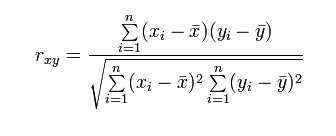


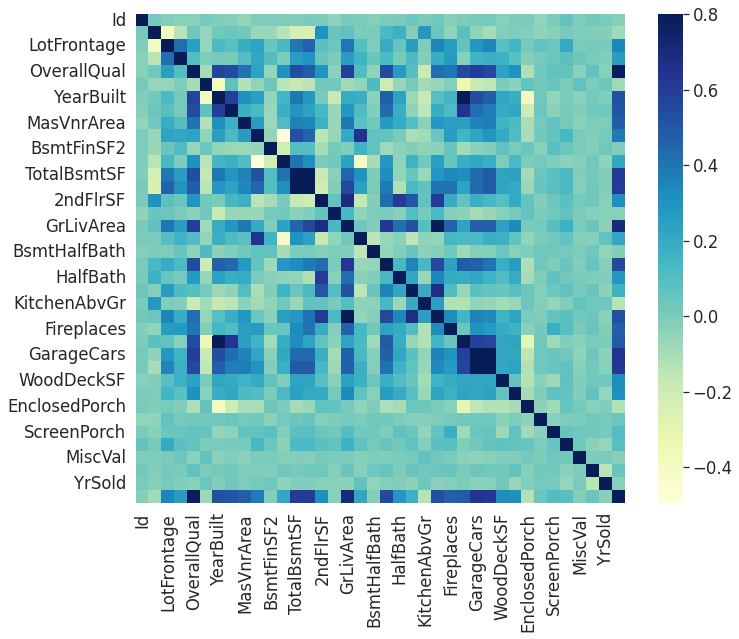

In [123]:
## Establishing a heatmap using the above correlation matrix.

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation_matrix, cmap='YlGnBu', vmax=.8, square=True);

A heatmap shows not just how the features correlate with the target, but with each other as well. This will help show if multicollinearity exists between the features. Multicollinearity is undesirable because it could throw off the weights of the features (the coefficients) in linear predictions. It also could show feature redundancy, such as the same feature expressed in different units (inches vs feet). 

It is important to consider what the features themselves represent. For example, OverallCond is the overall condition of the house, which is essentially the same as OverallQual - the overall quality of the house. OverallQual has a high correlation to the target, so that could mean that OverallCond is a redundant feature.

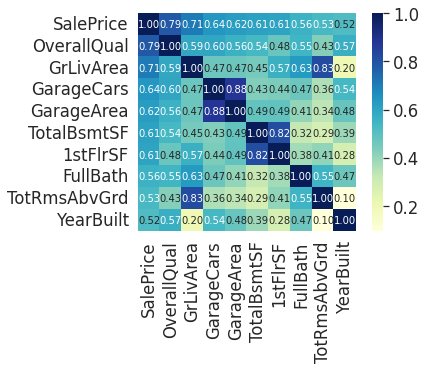

In [124]:
## "Zoomed-in" correlation matrix for most heavily correlated features to target.
k = 10 #number of variables for heatmap
columns = correlation_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(trainingset[columns].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, cmap='YlGnBu', fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

After looking at the following "zoomed-in" correlation heatmap, we can see 1stFlrSF is decently correlated with the target. 1stFlrSF, 2ndFlrSF and TotalBsmtSF can be combined into a TotalSqFt feature that could have better correlation to the target.

In [125]:
## Creating a new feature (column) by combining the 1stFlrSF, 2ndFlrSF and TotalBsmtSF features.

trainingset['TotalSqFt'] = trainingset['1stFlrSF']+trainingset['2ndFlrSF']
testset['TotalSqFt'] = testset['1stFlrSF']+testset['2ndFlrSF']

In [126]:
## Re-establishing the correlation matrix including the newly created feature.

correlation_matrix = trainingset.corr()
correlation_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
TotalSqFt        0.716883
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr

As we can see, the new feature is now the third most heavily correlated feature to the target. This is powerful, as more features is more information that can be used in predictions. However, more features usually means more computational power and data storage. Since this is a small dataset of only (starting) 80 features, adding more features will not substantially increase the amount of computational power and data storage that we will need.

Now is a good point to look more into the missing data.

In [127]:
# A better idea of how much data is missing from the features.

total = trainingset.isnull().sum().sort_values(ascending=False)
percent = (trainingset.isnull().sum()/trainingset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479


Here we have percentages of how much data is missing from each feature. We can decide how big of a percent makes sense on eliminating features from the dataset. In data pipelines, you can establish a threshold to automatically drop features that are missing too many data instances, such as 0.8 for 80%. However, it is also good to look into features before dropping them.

In [128]:
## Looking into PoolQC, the dataset missing the most values.

trainingset['PoolQC'].value_counts() ## Since this is a categorical feature (object datatype), we can count how many categories and how many iterations of those categories there are.

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

There really isn't much here to work with. There are only 7 instances that hold actual values, and 'NaN' doesn't necessarily mean that the house has no pool. There is also no 'Bad' condition for the pool, so it is easy to assume that this feature is simply incomplete and can be removed.

In [129]:
trainingset['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

The next feature up to the chopping block, MiscFeature, is also missing a large majority of instances. These features are described in the data description given in the Kaggle competition. While sheds are an important factor (as are tennis courts 'TenC'), there is still simply not enough instances of the categories to warrant keeping. While more information can be a good thing in model training, categorical features will need to be encoded to allow for the actual training and prediction in a linear regression model. Encoding is a process that creates an entire feature built from 1's and 0's for each category, which can bog down the model training to make it take longer. Long training times is a hazard when dealing with data pipelines for continuous streaming, especially with big data. Given that fact, and that we cannot simply assume that all the missing data values can be filled with sheds, we can logically remove this feature as well. 

In [130]:
## Next feature that is missing values.

trainingset['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

This looks like the same issue as above in MiscFeature. Not enough data instances to warrant keeping.

In [131]:
trainingset['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Same situation here for Fence.

In [132]:
trainingset['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

A bulk of the fireplaces are either Gd (Good) or TA (Average). We could fill half of missing values with Gd and half with TA, but that may bias the feature. Logically, most fireplaces are either good or average. Again, may just be acceptable to remove this feature.

In [133]:
trainingset['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

LotFrontage is next, which is a numerical feature missing around 18% of its data values. We can see here that the values range from 21 to 313, giving us a median of 69. We can see that the mean is close to the median, so that means the data has a symmetrical distribution. Good information to know, and filling in the missing data with either the mean or the median would work for this feature.

The rest of the features do not have a significant amount of data missing. They can be filled in with the median for numerical features, and the most frequent for categories. Let's go ahead and drop the features that we determined are not worth keeping.


Now it's time to look at the comparison between OverallCond and OverallQual. They appear to be the same, while OverallCond has very little correlation with the target and other features. We can compare these two features visually.

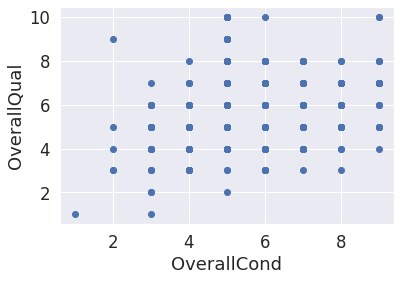

In [134]:
## Plotting OverallCond vs OverallQual
plt.scatter(x=trainingset['OverallCond'], y=trainingset['OverallQual'])
plt.ylabel('OverallQual')
plt.xlabel('OverallCond')
plt.show()

Visualizing the values in both, we can see that these two features do not correlate well. Since OverallQual is highly correlated to the target, we can go ahead and keep that feature and get rid of OverallCond.

In [135]:
## Dropping features in both the trainingset and the testset.

trainingset = trainingset.drop(columns=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature', 'OverallCond'])
testset = testset.drop(columns=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature','OverallCond'])

Thus ends the "extraction" or "ingestion" point of the script. Assuming this is an ETL system, which is one of the most common data processes, we can now transform the data before loading it into a database.  

# Data Transformation

To start with the data transformation, we can look into filling the missing data instances.

In [136]:
## Fitting models requires a separate y array, so we'll split the training data here.

y = trainingset['SalePrice'] 

In [137]:
## Dropping the target from the training set, no need to do it to the test set since it isn't present in it.

trainingset = trainingset.drop(columns = 'SalePrice') 

In [138]:
## Separating the training set and test set by numerical and categorical features.

trainset_nums = trainingset.select_dtypes(np.number) ## numericals
trainset_cats = trainingset.select_dtypes([object]) ## categoricals

In [139]:
## Test set split.

testset_nums = trainingset.select_dtypes(np.number) ##numericals
testset_cats = trainingset.select_dtypes([object]) ## categoricals

In [140]:
## Imputing missing values using the median of each feature in the numerical training dataset.

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
trainset_numfilled = imputer.fit_transform(trainset_nums)

In [141]:
## Transforming the test set using the parameters fit from the training set.

testset_numfilled = imputer.transform(testset_nums) 

An important note here: When transforming a data set for model predictions, fitting the transformer to the training set first is crucial. Then, transform the test set with the same parameters used to transform the training set. This is due to the fact that we do not know the parameters of the test set whatsoever, as well as to keep the data consistent on the same scale. Doing this avoids data leakage, which could make the model overconfident and inefficient for extrapolation.

In [142]:
## Creating pandas dataframes for the numerical features of the training set and test set to allow for easy concatenation later on.

trainset_numfilled = pd.DataFrame(trainset_numfilled,columns=trainset_nums.columns) 

testset_numfilled = pd.DataFrame(testset_numfilled,columns=testset_nums.columns)

In [143]:
## Encoding categorical features to become numerical values. Our models later on require all numerical features.

from sklearn.preprocessing import OneHotEncoder 
ohc = OneHotEncoder(drop='first', sparse=False)  ## Dropping the first category of each feature. Avoiding a sparse matrix as dense matrices are easier to work with (with smaller data).

Now it is time to encode the categorical features to become numerical representations of each category. These are also known as 'dummy variables'. Each category of each feature will be encoded to be a binary vector (column). 

Dropping one of the categories per feature to avoid dummy variable trap. Avoids creating multicollinear variables when encoding categorical features.

In [144]:
## Creating a pandas dataframe for the training set and test set encoded categorical features. 

encoded_traincats = pd.DataFrame(ohc.fit_transform(trainset_cats)) ## Train set

encoded_testcats = pd.DataFrame(ohc.transform(testset_cats)) ## Test set

With the missing data imputed for the numerical features, and the categorical features encoded, now it is time to look into the predictive target.

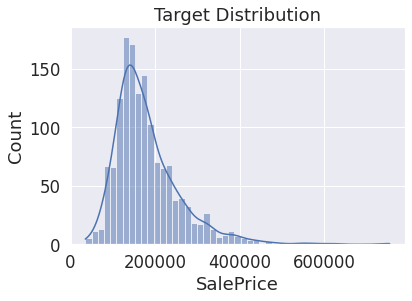

<Figure size 432x288 with 0 Axes>

In [145]:
from scipy import stats

sns.histplot(data = y, kde=True); ## Plotting a histogram of the target 'SalePrice' stored in variable 'y'. KDE will be plotted on-top of the histogram plot.
plt.title('Target Distribution')
plt.ylabel('Count')
plt.xlabel('SalePrice')
fig = plt.figure()

The target is skewed to the right (positive).  The Kermal Density Estimate (KDE) plot shows the overall shape of the skew. Histogram plots give a rough shape of the data depending on how many bins are included in the plot, whereas the KDE plot uses all data points and plots along the density of the set, not just peak values. Both are useful together to see the peaks of the data, as well as a good overall shape.

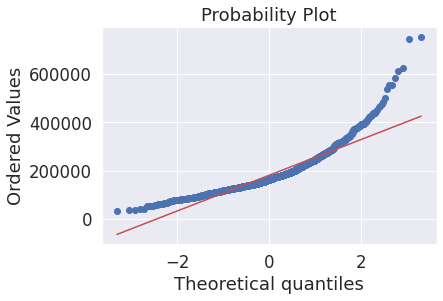

In [146]:
## Plotting a probability plot

res = stats.probplot(y, plot=plt)

The probability plot shows that the data currently does not follow a good normal distribution, therefore extrapolation will not be very effective given how the target data is skewed. Linearizing the data through a scale would eliminate the skew.

In [147]:
## Scaling the data by taking the natural log of the target.

y = np.log1p(y)

The above calculates log(1+y) of the data set for each instance (or element) of the target array. Adding 1 inside the log ensures that we won't run into the issue of a 0 value being in the target data. Taking the log of the data will essentially eliminate the skew, condensing the larger data values that are causing the right-hand skew into smaller values closer to the mean. This leads to a symmetric normal distribution (also known as Gaussian distribution) at the mean of the data. In other words, log changes the range of values in the data.

*Note that this is not a standard normal distribution, which would have mean located at 0 and a unit variance of 1.

**Variance** is the average squared deviations from the mean, while standard deviation is the square root of this number. Unit variance is simply dividing all data values by the standard deviation. This ensures proportionate contribution from all the features.

**Standard deviation** is the average amount of variability in the dataset. It shows on average how far each value lies from the mean. 

Now that the data has been scaled by log, we can check the skew and probability plot again.

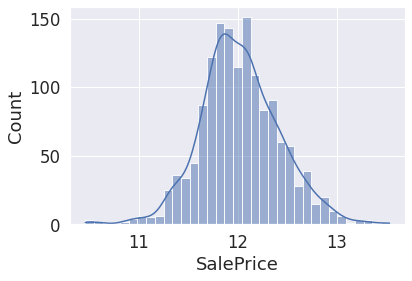

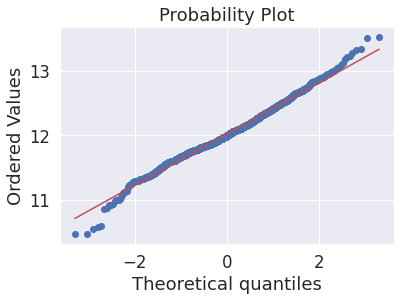

In [148]:
sns.histplot(data = y, kde=True);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

As we can see, the histogram/KDE plot shows that the data is distributed normally where the center is the mean of the data, which will make predictions much more accurate in regression models. The probability plot also shows that the data is normally distributed, which will allow the model to extrapolate more efficiently.

In [149]:
from sklearn.preprocessing import StandardScaler 

sc = StandardScaler() # No parameters needed
trainset_numfilled = pd.DataFrame(sc.fit_transform(trainset_numfilled, y), columns = trainset_nums.columns) ## Establishing a pandas dataframe for the test set and 
testset_numfilled = pd.DataFrame(sc.transform(testset_numfilled)) 

StandardScaler is a good way to ensure all numerical data is on the same scale by removing the mean and scaling to unit variance. This scaling maintains the weight coefficients of each feature, while ensuring no feature dominates others in terms of magnitude.  

The way this works is that StandardScaler normalizes the features individually, where each feature will have a mean of 0 and standard deviation of 1. The values are calculated to be how many standard deviations the original value was from the mean. The range of the scaled data will depend on the dataset and is not predetermined. (Unlike normalization, which would result in a range of values equal to 0 to 1.)

In [150]:
## Resetting indices for concatenation for both training set and test set. 

trainset_numfilled.reset_index(drop=True, inplace=True) # Training set
encoded_traincats.reset_index(drop=True, inplace=True)


testset_numfilled.reset_index(drop=True, inplace=True) # Test set
encoded_testcats.reset_index(drop=True, inplace=True)

Prepping data for concatenation by resetting the indices. This ensures that the indices between the two datasets will allign. If the indices are mis-alligned, NaN values will be returned.

In [151]:
## Concatenating the transformed numerical and categorical features into a final training set.

trainset_total = pd.concat([trainset_numfilled,encoded_traincats],axis=1)

In [152]:
## Concatenating the transformed numerical and categorical features into a final test set.

testset_total = pd.concat([testset_numfilled,encoded_testcats],axis=1)

# Model Training & Prediction

From here we will be building machine learning models. I have not gone into depth on underfitting and overfitting, aka the bias vs variance tradeoff. But if the r2 score is very low, we can assume that the model is underfitting (high biased). However, if the r2 score is too high this could indicate overfitting (high variance). Using the Mean Squared Error (MSE) and Mean Absolute Error (MBE) give us a better indication of the performance of the model. I will be looking into all of these numbers as I score each model's efficiency.

In [153]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Defining a function to quickly score the models.

def GetErrors(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred) ## Mean Squared Error. Closer to 0 is better.
  rmse = mean_squared_error(y_true, y_pred, squared = False) ## Root Mean Squared Error. Closer to 0 is better.
  mae = mean_absolute_error(y_true, y_pred) ## Mean Absolute Error. Close to 0 is better.
  r2 = r2_score(y_true, y_pred) ## Suppose to be between 0 and 1. Closer to 1 is better. Negative means poorly fitting model.
  print('MSE is: {}'.format(mse))
  print('RMSE is: {}'.format(rmse))
  print('MAE is: {}'.format(mae))
  print('R Squared is: {}'.format(r2))

In [154]:
## To begin, we test the data in a simple Linear Regression model.

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(np.array(trainset_total),np.array(y))
lr_prediction = lr.predict(np.array(testset_total))

In [157]:
GetErrors(y, lr_prediction) ## Calling the defined function for the four parameters of effiency declared before.

MSE is: 0.013091279562713371
RMSE is: 0.11441712967346004
MAE is: 0.08396257483596181
R Squared is: 0.9178974983314034


Here we can see the R^2 value is 91%, which is a good indication that the model is fit well to the training data. The MSE value of 1.3% indicates that the error difference between the predicted value and the actual value (the 'SalePrice' y variable) is quite small. Overall this is not a bad model. 

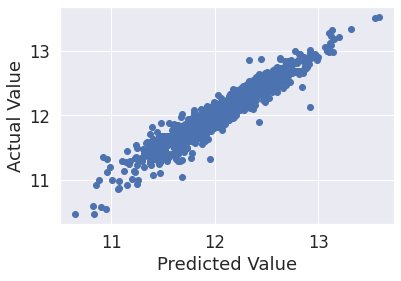

In [155]:
plt.scatter(x=lr_prediction, y=y)
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.show()

Plotting the actual data vs predicted values, we can see that there are some outliers, but otherwise the data is fairly linear.

Next we will try a Support Vector Regression model.

In [158]:
## Support Vector Regressor (SVR)

from sklearn.svm import SVR
svr_reg = SVR(kernel = 'poly') ## Using a polynomial kernel, saw more effiency than the other kernels.
svr_reg.fit(np.array(trainset_total), np.array(y))
svr_pred = svr_reg.predict(np.array(testset_total))

In [159]:
GetErrors(y, svr_pred)

MSE is: 0.005913115735624703
RMSE is: 0.07689678625030244
MAE is: 0.06439258410660226
R Squared is: 0.9629156499007567


The SVR model did considerably better than the linear regression model, this was to be expected as the SVR model does not factor in outliers as much as the linear regression model does.

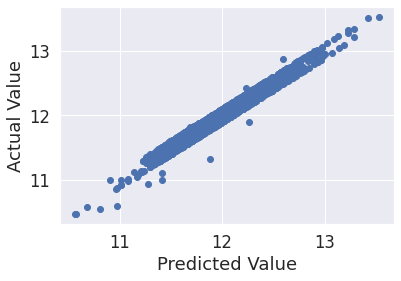

In [160]:
plt.scatter(x=svr_pred, y=y)
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.show()

Very linear, with some outliers.

In [162]:
## Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 1000) ## n_estimators is the amount of trees.
regressor.fit(np.array(trainset_total), np.array(y))
rdmfrst = regressor.predict(np.array(testset_total))

Random Forest Regression is an ensemble model, which means that it "stacks" the outputs of many different Forest Tree models and uses their predictions in its own prediction. The default amount of trees for sklearn's RandomForestRegressor is 100, but it is more powerful to use more trees (n_estimator). However, this requires more computational power and will increase the time it takes for training the model. Therefore, one should be careful using Random Forest Regressors in streaming processing and any other automated processing that needs to be done quickly.

In [164]:
GetErrors(y, rdmfrst)

MSE is: 0.002881699770808193
RMSE is: 0.05368146580346138
MAE is: 0.03579695729285229
R Squared is: 0.9819273006043623


Here we can see an R^2 value of 98%, with an MSE of 0.28% This indicates that the model is fit well to the data, with a prediction error that's very low.

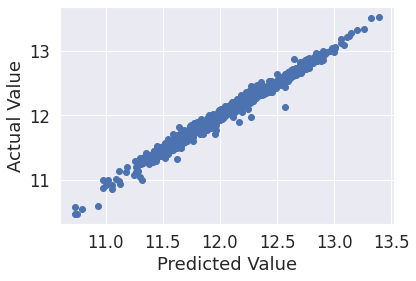

In [165]:
plt.scatter(x=rdmfrst, y=y)
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.show()

Visualizing the errors shows that the predictions vs actual values is linear and the line is tight. The Random Forest Regressor is the best pick out of the three models.